# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File Path

In [2]:
df = pd.read_csv('balanced_data.csv')

# Understanding Our Data

In [3]:
df.shape

(1061, 13)

In [4]:
df.head()

,Unnamed: 0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1061 non-null   int64  
 1   PassengerId  1061 non-null   int64  
 2   Survived     1061 non-null   int64  
 3   Pclass       1061 non-null   int64  
 4   Name         1061 non-null   object 
 5   Sex          1061 non-null   object 
 6   Age          852 non-null    float64
 7   SibSp        1061 non-null   int64  
 8   Parch        1061 non-null   int64  
 9   Ticket       1061 non-null   object 
 10  Fare         1061 non-null   float64
 11  Cabin        233 non-null    object 
 12  Embarked     1058 non-null   object 
dtypes: float64(2), int64(6), object(5)
memory usage: 107.9+ KB


In [6]:
df['Survived'].value_counts()

Survived
0    549
1    512
Name: count, dtype: int64

# Exploratory Data Analysis

In [7]:
useless_columns = ['PassengerId', 'Cabin', 'Ticket', 'Unnamed: 0'] 
df.drop(useless_columns, axis = 1, inplace = True)

In [8]:
def one_hot_encode_column_inplace(df, column, prefix = None, drop_first = True):
    if column not in df.columns:
        raise ValueError(f'Column "{column}" not found in DataFrame.')

    dummies = pd.get_dummies(df[column], prefix = prefix or column, drop_first = drop_first)
    df = df.drop(columns = [column]).join(dummies)
    return df

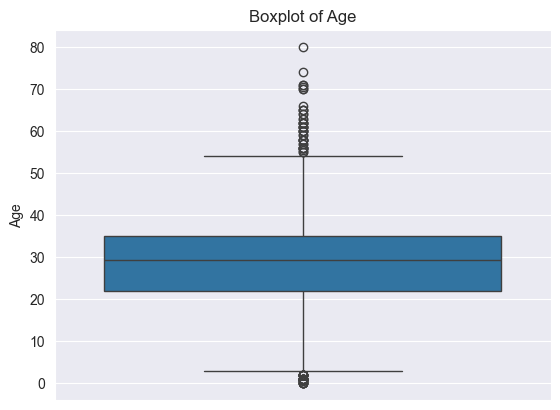

In [9]:
# Age Column Fill NAN With Mean
df['Age'] = df['Age'].fillna(df['Age'].mean())

# Age Check For Outliers
sns.boxplot(df['Age'])
plt.title('Boxplot of Age')
plt.show()

In [10]:
corr_value = df['Survived'].corr(df['Age'])
print(corr_value)

-0.07822979476865599


In [11]:
# Age Treating Outliers
Q1 = df['Age'].quantile(0.25)
Q3 = df['Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

def cap_values(x, lower, upper):
    if x < lower:
        return lower
    elif x > upper:
        return upper
    else:
        return x

df['Age'] = df['Age'].apply(cap_values, lower = lower_bound, upper = upper_bound)

In [12]:
# Sex Column LabelEncoding
df = one_hot_encode_column_inplace(df, column = 'Sex', prefix = 'Sex', drop_first = True)

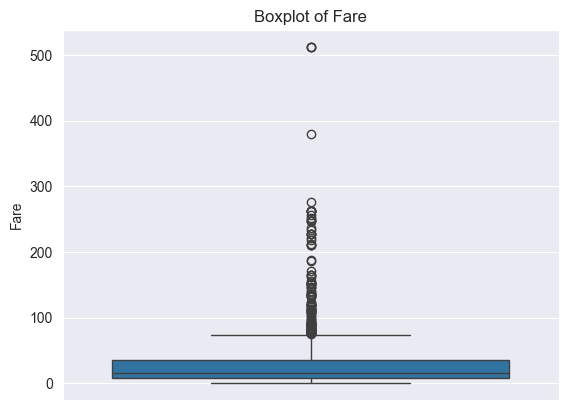

In [13]:
# Fare Column Check For Outliers
sns.boxplot(df['Fare'])
plt.title('Boxplot of Fare')
plt.show()

In [14]:
corr_value = df['Survived'].corr(df['Fare'])
print(corr_value)

0.26147618055333466


In [15]:
df['Fare_log'] = np.log1p(df['Fare'])

In [16]:
corr_value = df['Survived'].corr(df['Fare_log'])
print(corr_value)

0.29812104977914033


# Feature Engineering

In [17]:
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

In [18]:
df['Title'] = df['Title'].replace({
    'Mlle': 'Miss',
    'Ms': 'Miss',
    'Mme': 'Mrs',
    'Lady': 'Rare',
    'Countess': 'Rare',
    'Capt': 'Rare',
    'Col': 'Rare',
    'Don': 'Rare',
    'Dr': 'Rare',
    'Major': 'Rare',
    'Rev': 'Rare',
    'Sir': 'Rare'
})

In [19]:
# Drop Name Column
df.drop('Name', axis = 1, inplace = True)

In [20]:
# Title Column OneHotEncoding
df = one_hot_encode_column_inplace(df, column = 'Title', prefix = 'Title', drop_first = True)

In [21]:
# New Column
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [22]:
df['AgeBin'] = pd.cut(df['Age'], bins = [0, 12, 20, 40, 60, 80], labels = ['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

In [23]:
df = one_hot_encode_column_inplace(df, column = 'AgeBin', prefix = 'AgeBin', drop_first = True)

In [24]:
# Create interaction features
df['Sex_FareLog'] = df['Sex_male'] * df['Fare_log']
df['Sex_FamilySize'] = df['Sex_male'] * df['FamilySize']

In [25]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [26]:
df = one_hot_encode_column_inplace(df, column = 'Embarked', prefix = 'Embarked', drop_first = True)

In [27]:
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=False)

In [28]:
correlations = df.corr(numeric_only = True)['Survived'].dropna()
correlations = correlations.abs().sort_values(ascending = False)
correlations = correlations.drop('Survived', errors = 'ignore')
top_features = correlations.head(35)
top_features_list = top_features.index.tolist()
print(top_features_list)

['Sex_male', 'Title_Mr', 'Sex_FareLog', 'FareBin', 'Pclass', 'Title_Miss', 'Title_Mrs', 'Sex_FamilySize', 'Fare_log', 'Fare', 'Embarked_S', 'Parch', 'Title_Master', 'Age', 'SibSp', 'AgeBin_Adult', 'AgeBin_Middle', 'Embarked_Q', 'FamilySize', 'AgeBin_Teen', 'Title_Rare']


# Logistic Regression Model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

# Define features and target
features = ['Sex_male', 'Title_Mr', 'Sex_FareLog', 'Pclass', 'Title_Miss', 'Title_Mrs', 'Sex_FamilySize', 'Fare_log', 'Fare', 'Embarked_S', 'Parch', 'Age', 'SibSp', 'AgeBin_Adult', 'AgeBin_Middle', 'Embarked_Q', 'FamilySize', 'AgeBin_Teen', 'Title_Rare']


# Prepare data
X = df[features]
y = df['Survived']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model = LogisticRegression(penalty = 'l2', class_weight = 'balanced', max_iter = 500, C = 1.0, solver = 'liblinear', random_state = 42)

model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8263
F1 Score: 0.8159

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       111
           1       0.83      0.80      0.82       102

    accuracy                           0.83       213
   macro avg       0.83      0.83      0.83       213
weighted avg       0.83      0.83      0.83       213

